In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim

from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys

from glob import glob
from PIL import Image
import os


In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(2*32*100*100, 500)
        #self.fc1 = nn.Linear(2*1000, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2)


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output


In [3]:
model = SiameseNetwork()
checkpoint = torch.load("checkpoint.pth",map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [5]:
import os
data_path = 'images'


def get_data_images(data_path,number_of_paired=2,number_of_different=3):
    
    data_dir_list = os.listdir(data_path)
    data_dir_list.sort()
#     print(data_dir_list)
    data = []
    c = 0
    while c < len(data_dir_list)-1:
        code1 = data_dir_list[c].split("_")[0]
        code2 = data_dir_list[c + 1].split("_")[0]
        if code1 == code2:
            
            path1 = os.path.join(data_path, data_dir_list[c])
            path2 = os.path.join(data_path, data_dir_list[c])
            
            data.append([path1, path2, 0])
            c += 1
        c += 1
    data = data[:number_of_paired]
    
    import random
    for i in range(len(data_dir_list)):
        filename1 = data_dir_list[i]
        filename2 = random.choice(data_dir_list)
        while filename1.split("_")[0] == filename2.split("_")[0]:
            filename2 = random.choice(data_dir_list)
        filename1 = os.path.join(data_path, filename1)    
        filename2 = os.path.join(data_path, filename2)
        data.append([filename1, filename2, 1])
    data = data[:(number_of_paired+number_of_different)]
#     random.shuffle(data)
    return data

In [32]:
def getimgs(img1_path, img2_path):

    # print(img1_path,img2_path)
    transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()
    
    img1 = img1.convert('RGB')
    img2 = img2.convert('RGB')
    img1 = transform(img1)
    img2 = transform(img2)

    img1 = img1.unsqueeze(0)
    img2 = img2.unsqueeze(0)

#     img1, img2  = img1.cuda(), img2.cuda()
    return img1, img2

In [38]:
def pred(data,net):
    predictions = []
    net.eval()
    with torch.no_grad():
        for img1_path, img2_path, cls_ in data:
            
#             img1_path = os.path.join(dir_data_path, img1_path)
#             img2_path = os.path.join(dir_data_path, img2_path)
    
            img1, img2 = getimgs(img1_path, img2_path)
        
            outputs = net(img1,img2)
            _, predicted = torch.max(outputs, 1)
            label = predicted.cpu().numpy()[0]
            if label == 0:
                print("SAME OBJECTS")
            else:
                print("DIFFERENT OBJECTS")
            predictions.append(label)
    return (predictions)

In [36]:
data = get_data_images(data_path)
data

[['images/1220000150683_1.jpg', 'images/1220000150683_1.jpg', 0],
 ['images/40084701_1.jpg', 'images/40084701_1.jpg', 0],
 ['images/1220000150683_1.jpg', 'images/3010470169401_1.jpg', 1],
 ['images/1220000150683_2.jpg', 'images/40084701_1.jpg', 1],
 ['images/3010470169401_1.jpg', 'images/1220000150683_1.jpg', 1]]

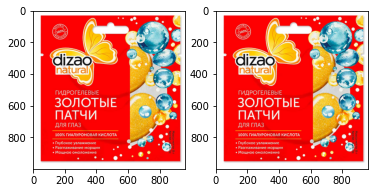

SAME OBJECTS


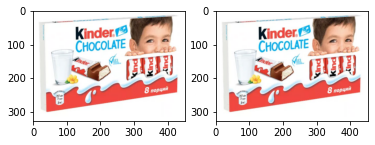

SAME OBJECTS


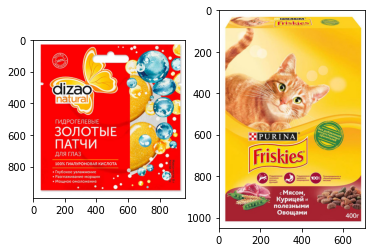

DIFFERENT OBJECTS


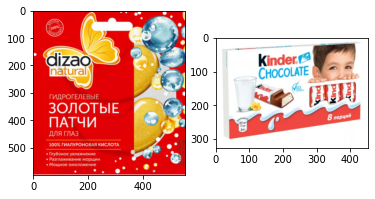

DIFFERENT OBJECTS


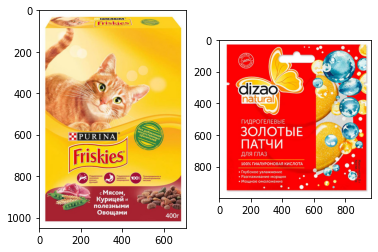

DIFFERENT OBJECTS


In [39]:
y_pred = pred(data, model)